<a href="https://colab.research.google.com/github/janettgarciiaa/Project_1/blob/main/Project_1_Week_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Features you'll model (custom to you)
FEATURES = [
    "workday",        # 0/1
    "steps",          # integer
    "sleep_hours",    # float
    "water_oz",       # float
    "caffeine_mg",    # integer
    "stress_1_5",     # 1..5
    "study_minutes",  # integer
    "period_phase"    # 0/1 (optional)
]
TARGET = "energy_score"  # 0..100

In [ ]:
def make_synthetic_energy_data(n=800):
    # Generate realistic-ish daily data
    workday = np.random.binomial(1, 0.7, size=n)
    steps = np.random.normal(7000, 2500, size=n).clip(500, 20000)
    sleep = np.random.normal(7.2, 1.1, size=n).clip(3.5, 10)
    water = np.random.normal(70, 25, size=n).clip(0, 160)
    caffeine = np.random.normal(120, 80, size=n).clip(0, 400)
    stress = np.random.randint(1, 6, size=n)
    study = np.random.normal(60, 40, size=n).clip(0, 240)
    period = np.random.binomial(1, 0.2, size=n)

    X = np.column_stack([workday, steps, sleep, water, caffeine, stress, study, period])

    # Your "true" relationship (make it yours!)
    beta0 = 15.0
    betas = np.array([
        -3.0,     # workday
        0.0015,   # steps
        5.0,      # sleep_hours
        0.05,     # water_oz
        -0.03,    # caffeine_mg
        -4.0,     # stress_1_5
        0.02,     # study_minutes
        -6.0      # period_phase
    ])
    noise = np.random.normal(0, 5.0, size=n)

    y = beta0 + X @ betas + noise
    y = np.clip(y, 0, 100)  # keep like a 0–100 self rating

    df = pd.DataFrame(X, columns=FEATURES)
    df[TARGET] = y
    return df

df = make_synthetic_energy_data(n=800)
print(df.shape)
df.head()

(800, 9)


,workday,steps,sleep_hours,water_oz,caffeine_mg,stress_1_5,study_minutes,period_phase,energy_score
0,1.0,5023.813861,7.792126,61.041496,216.020940,1.0,59.205055,0.0,52.162422
1,0.0,8178.670893,8.379758,53.811455,82.947091,5.0,55.709409,0.0,45.601145
2,0.0,11705.061241,6.798552,88.604799,87.085871,5.0,108.811316,1.0,44.317970
3,1.0,10363.550115,6.276869,65.469396,212.312059,2.0,16.932835,0.0,42.006930
4,1.0,10982.966567,6.050710,53.765674,0.000000,2.0,29.499230,0.0,60.961129


In [ ]:
from sklearn.model_selection import train_test_split

# Shuffle/split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Standardize using TRAIN stats only (avoid leakage)
mu = train_df[FEATURES].mean()
sigma = train_df[FEATURES].std(ddof=0).replace(0, 1.0)

X_train = ((train_df[FEATURES] - mu) / sigma).to_numpy(dtype=np.float32)
y_train = train_df[TARGET].to_numpy(dtype=np.float32).reshape(-1, 1)

X_val = ((val_df[FEATURES] - mu) / sigma).to_numpy(dtype=np.float32)
y_val = val_df[TARGET].to_numpy(dtype=np.float32).reshape(-1, 1)

# DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train)),
                          batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),
                          batch_size=batch_size, shuffle=False)

n_features = X_train.shape[1]
n_features

8

In [ ]:
class WellnessRegressor(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)  # y = XW + b

    def forward(self, x):
        return self.linear(x)

model = WellnessRegressor(n_features)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)  # try 0.01–0.1 if needed

model

WellnessRegressor(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [ ]:
def run_epoch(loader, train=True):
    total_loss, n = 0.0, 0
    model.train() if train else model.eval()
    for xb, yb in loader:
        if train: optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * len(xb)
        n += len(xb)
    return total_loss / n

num_epochs = 100
train_losses, val_losses = [], []
print("Epoch | train_loss | val_loss")
print("-"*30)
for epoch in range(num_epochs):
    tl = run_epoch(train_loader, train=True)
    vl = run_epoch(val_loader, train=False)
    train_losses.append(tl); val_losses.append(vl)
    if (epoch+1) % 10 == 0:
        print(f"{epoch+1:5d} | {tl:10.4f} | {vl:8.4f}")

Epoch | train_loss | val_loss
------------------------------
   10 |    27.6975 |  21.0388
   20 |    27.7204 |  21.2315
   30 |    27.7879 |  21.2566
   40 |    27.7723 |  21.4024
   50 |    27.7789 |  21.1502
   60 |    27.7941 |  21.1518
   70 |    27.7374 |  21.4086
   80 |    27.7831 |  21.2035
   90 |    27.7710 |  21.3008
  100 |    27.7967 |  21.4334


In [ ]:
@torch.no_grad()
def evaluate_and_weights():
    model.eval()
    Xv = torch.from_numpy(X_val)
    yv = torch.from_numpy(y_val)
    pv = model(Xv)

    ss_res = torch.sum((yv - pv)**2).item()
    ss_tot = torch.sum((yv - yv.mean())**2).item()
    r2 = 1 - ss_res/ss_tot
    mse = ss_res / len(yv)

    # Convert weights from standardized space back to original units
    W_std = model.linear.weight.detach().cpu().numpy().flatten()
    b_std = model.linear.bias.detach().cpu().item()

    slopes = pd.Series(W_std, index=FEATURES) / sigma
    intercept = b_std - np.sum(mu.values * (W_std / sigma.values))

    return r2, mse, slopes.sort_values(key=np.abs, ascending=False), intercept

r2, mse, slopes, intercept = evaluate_and_weights()
print(f"Validation R²: {r2:.3f} | MSE: {mse:.3f}\n")
print("Top feature effects (abs):")
display(slopes.to_frame("slope_in_original_units"))
print(f"\nIntercept (original scale): {intercept:.2f}")

Validation R²: 0.828 | MSE: 21.433

Top feature effects (abs):


,slope_in_original_units
period_phase,-6.263675
sleep_hours,5.230713
stress_1_5,-4.015821
workday,-3.349565
water_oz,0.036416
caffeine_mg,-0.029610
study_minutes,0.025316
steps,0.001489



Intercept (original scale): 14.04


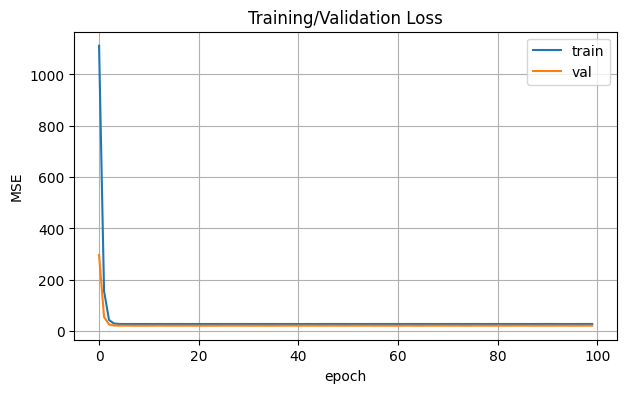

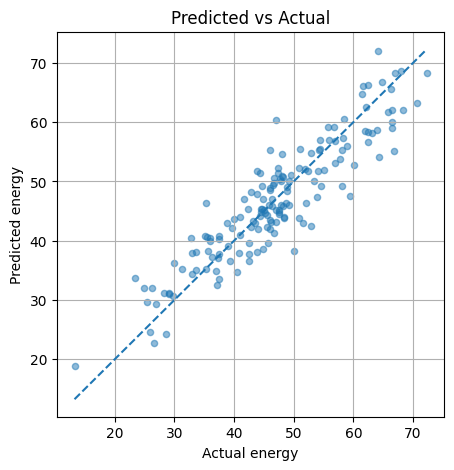

In [ ]:
# Loss curves
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch"); plt.ylabel("MSE")
plt.title("Training/Validation Loss")
plt.grid(True); plt.legend(); plt.show()

# Predicted vs Actual
with torch.no_grad():
    pv = model(torch.from_numpy(X_val)).numpy().flatten()
    yv = y_val.flatten()

plt.figure(figsize=(5,5))
plt.scatter(yv, pv, alpha=0.5, s=20)
lims = [min(yv.min(), pv.min()), max(yv.max(), pv.max())]
plt.plot(lims, lims, linestyle="--")
plt.xlabel("Actual energy"); plt.ylabel("Predicted energy")
plt.title("Predicted vs Actual")
plt.grid(True); plt.show()